# TP no 4 : Support vector machine (SVM)

In [71]:
from sklearn.svm import SVC
import random as rd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import neighbors, model_selection
import seaborn as sns
from matplotlib.colors import ListedColormap
import pylab as pl

from time import time
import logging

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [72]:
###############################################################################
#               Data Generation
###############################################################################


def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

###############################################################################
#           Displaying labeled data
###############################################################################

symlist = ['o', 's', 'D', 'x', '+', '*', 'p', 'v', '-', '^']


def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c=np.reshape(color_blind_list[i], (1, -1)), s=80,
                    marker=symlist[i])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)


###############################################################################
#           Displaying tools for the Frontiere
###############################################################################


def frontiere(f, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
              samples=True):
    """ trace la frontiere pour la fonction de decision f"""
    # construct cmap

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f([vec]) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1],
                        c=np.reshape(color_blind_list[label_num], (1, -1)),
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)


def plot_gallery(images, titles, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,
                       hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i])
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


def title(y_pred, y_test, names):
    pred_name = names[int(y_pred)].rsplit(' ', 1)[-1]
    true_name = names[int(y_test)].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

### Question 1 :

In [73]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
iris = datasets.load_iris()
X = iris.data
X = scaler.fit_transform(X)
y = iris.target
X = X[y != 0, :2]
Y = y[y != 0]

In [74]:
xtrain = []
while(len(xtrain) < 50):
    rand = rd.randrange(99)
    if not(rand in xtrain):
        xtrain.append(rand)
xother = [i for i in range(99) if not(i in xtrain)]

Xtrain = X[xtrain]
Xtest = X[xother]

Ytrain = Y[xtrain]
Ytest = Y[xother]

In [75]:
model = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='linear'))
model.fit(Xtrain, Ytrain)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='auto',
                     kernel='linear', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [76]:
model.score(Xtest, Ytest)

0.7346938775510204

In [77]:
model.score(Xtrain, Ytrain)

0.72

(2500, 2)


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\antoi\Anaconda3\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "C:\Users\antoi\Anaconda3\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "C:\Users\antoi\Anaconda3\lib\site-packages\matplotlib\backends\_backend_tk.py", line 270, in idle_draw
    self.draw()
  File "C:\Users\antoi\Anaconda3\lib\site-packages\matplotlib\backends\backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "C:\Users\antoi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py", line 393, in draw
    self.figure.draw(self.renderer)
  File "C:\Users\antoi\Anaconda3\lib\site-packages\matplotlib\backend_bases.py", line 1556, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done: <matplotlib.backends.backend_agg.RendererAgg object at 0x00000290373EBC08>
Exception in Tkinter callback
Traceba

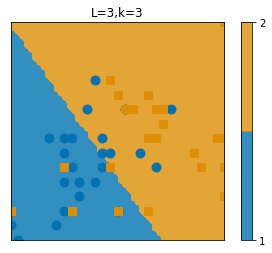

In [78]:
frontiere_new(model, Xtest, Ytest)

(2500, 2)


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\antoi\Anaconda3\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "C:\Users\antoi\Anaconda3\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "C:\Users\antoi\Anaconda3\lib\site-packages\matplotlib\backends\_backend_tk.py", line 270, in idle_draw
    self.draw()
  File "C:\Users\antoi\Anaconda3\lib\site-packages\matplotlib\backends\backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "C:\Users\antoi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py", line 393, in draw
    self.figure.draw(self.renderer)
  File "C:\Users\antoi\Anaconda3\lib\site-packages\matplotlib\backend_bases.py", line 1556, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done: <matplotlib.backends.backend_agg.RendererAgg object at 0x00000290375F13C8>
Exception in Tkinter callback
Traceba

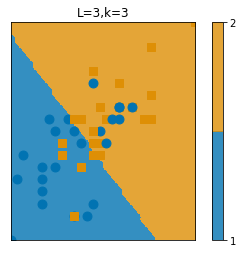

In [79]:
frontiere_new(model, Xtrain, Ytrain)

### Question 2

In [80]:
modelPoly = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='poly'))
modelPoly.fit(Xtrain, Ytrain)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='auto',
                     kernel='poly', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [81]:
modelPoly.score(Xtest, Ytest)

0.5306122448979592

In [82]:
modelPoly.score(Xtrain, Ytrain)

0.7

(2500, 2)


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\antoi\Anaconda3\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "C:\Users\antoi\Anaconda3\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "C:\Users\antoi\Anaconda3\lib\site-packages\matplotlib\backends\_backend_tk.py", line 270, in idle_draw
    self.draw()
  File "C:\Users\antoi\Anaconda3\lib\site-packages\matplotlib\backends\backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "C:\Users\antoi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py", line 393, in draw
    self.figure.draw(self.renderer)
  File "C:\Users\antoi\Anaconda3\lib\site-packages\matplotlib\backend_bases.py", line 1556, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done: <matplotlib.backends.backend_agg.RendererAgg object at 0x0000029037416348>
Exception in Tkinter callback
Traceba

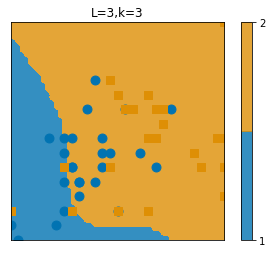

In [83]:
frontiere_new(modelPoly, Xtest, Ytest)

(2500, 2)


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\antoi\Anaconda3\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "C:\Users\antoi\Anaconda3\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "C:\Users\antoi\Anaconda3\lib\site-packages\matplotlib\backends\_backend_tk.py", line 270, in idle_draw
    self.draw()
  File "C:\Users\antoi\Anaconda3\lib\site-packages\matplotlib\backends\backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "C:\Users\antoi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py", line 393, in draw
    self.figure.draw(self.renderer)
  File "C:\Users\antoi\Anaconda3\lib\site-packages\matplotlib\backend_bases.py", line 1556, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done: <matplotlib.backends.backend_agg.RendererAgg object at 0x0000029037B1CA08>
Exception in Tkinter callback
Traceba

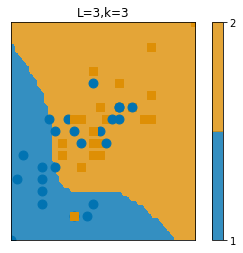

In [84]:
frontiere_new(modelPoly, Xtrain, Ytrain)

### Question 3 :

### Question 4 :

# GUI

In [85]:
import matplotlib
matplotlib.use('TkAgg')
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
try:
    from matplotlib.backends.backend_tkagg import NavigationToolbar2Tk
except ImportError:
    # NavigationToolbar2TkAgg was deprecated in matplotlib 2.2
    from matplotlib.backends.backend_tkagg import (
        NavigationToolbar2TkAgg as NavigationToolbar2Tk
    )
from matplotlib.figure import Figure
from matplotlib.contour import ContourSet

import sys
import numpy as np
import tkinter as Tk

from sklearn import svm
from sklearn.datasets import dump_svmlight_file

y_min, y_max = -50, 50
x_min, x_max = -50, 50


class Model:
    """The Model which hold the data. It implements the
    observable in the observer pattern and notifies the
    registered observers on change event.
    """

    def __init__(self):
        self.observers = []
        self.surface = None
        self.data = []
        self.cls = None
        self.surface_type = 0

    def changed(self, event):
        """Notify the observers. """
        for observer in self.observers:
            observer.update(event, self)

    def add_observer(self, observer):
        """Register an observer. """
        self.observers.append(observer)

    def set_surface(self, surface):
        self.surface = surface

    def dump_svmlight_file(self, file):
        data = np.array(self.data)
        X = data[:, 0:2]
        y = data[:, 2]
        dump_svmlight_file(X, y, file)


class Controller:
    def __init__(self, model):
        self.model = model
        self.kernel = Tk.IntVar()
        self.surface_type = Tk.IntVar()
        # Whether or not a model has been fitted
        self.fitted = False

    def fit(self):
        print("fit the model")
        train = np.array(self.model.data)
        X = train[:, 0:2]
        y = train[:, 2]

        C = float(self.complexity.get())
        gamma = float(self.gamma.get())
        coef0 = float(self.coef0.get())
        degree = int(self.degree.get())
        kernel_map = {0: "linear", 1: "rbf", 2: "poly"}
        if len(np.unique(y)) == 1:
            clf = svm.OneClassSVM(kernel=kernel_map[self.kernel.get()],
                                  gamma=gamma, coef0=coef0, degree=degree)
            clf.fit(X)
        else:
            clf = svm.SVC(kernel=kernel_map[self.kernel.get()], C=C,
                          gamma=gamma, coef0=coef0, degree=degree)
            clf.fit(X, y)
        if hasattr(clf, 'score'):
            print("Accuracy:", clf.score(X, y) * 100)
        X1, X2, Z = self.decision_surface(clf)
        self.model.clf = clf
        self.model.set_surface((X1, X2, Z))
        self.model.surface_type = self.surface_type.get()
        self.fitted = True
        self.model.changed("surface")

    def decision_surface(self, cls):
        delta = 1
        x = np.arange(x_min, x_max + delta, delta)
        y = np.arange(y_min, y_max + delta, delta)
        X1, X2 = np.meshgrid(x, y)
        Z = cls.decision_function(np.c_[X1.ravel(), X2.ravel()])
        Z = Z.reshape(X1.shape)
        return X1, X2, Z

    def clear_data(self):
        self.model.data = []
        self.fitted = False
        self.model.changed("clear")

    def add_example(self, x, y, label):
        self.model.data.append((x, y, label))
        self.model.changed("example_added")

        # update decision surface if already fitted.
        self.refit()

    def refit(self):
        """Refit the model if already fitted. """
        if self.fitted:
            self.fit()


class View:
    """Test docstring. """
    def __init__(self, root, controller):
        f = Figure()
        ax = f.add_subplot(111)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim((x_min, x_max))
        ax.set_ylim((y_min, y_max))
        canvas = FigureCanvasTkAgg(f, master=root)
        try:
            canvas.draw()
        except AttributeError:
            # support for matplotlib (1.*)
            canvas.show()
        canvas.get_tk_widget().pack(side=Tk.TOP, fill=Tk.BOTH, expand=1)
        canvas._tkcanvas.pack(side=Tk.TOP, fill=Tk.BOTH, expand=1)
        canvas.mpl_connect('button_press_event', self.onclick)
        toolbar = NavigationToolbar2Tk(canvas, root)
        toolbar.update()
        self.controllbar = ControllBar(root, controller)
        self.f = f
        self.ax = ax
        self.canvas = canvas
        self.controller = controller
        self.contours = []
        self.c_labels = None
        self.plot_kernels()

    def plot_kernels(self):
        self.ax.text(-50, -60, "Linear: $u^T v$")
        self.ax.text(-20, -60, r"RBF: $\exp (-\gamma \| u-v \|^2)$")
        self.ax.text(10, -60, r"Poly: $(\gamma \, u^T v + r)^d$")

    def onclick(self, event):
        if event.xdata and event.ydata:
            if event.button == 1:
                self.controller.add_example(event.xdata, event.ydata, 1)
            elif event.button == 3:
                self.controller.add_example(event.xdata, event.ydata, -1)

    def update_example(self, model, idx):
        x, y, l = model.data[idx]
        if l == 1:
            color = 'w'
        elif l == -1:
            color = 'k'
        self.ax.plot([x], [y], "%so" % color, scalex=0.0, scaley=0.0)

    def update(self, event, model):
        if event == "examples_loaded":
            for i in range(len(model.data)):
                self.update_example(model, i)

        if event == "example_added":
            self.update_example(model, -1)

        if event == "clear":
            self.ax.clear()
            self.ax.set_xticks([])
            self.ax.set_yticks([])
            self.contours = []
            self.c_labels = None
            self.plot_kernels()

        if event == "surface":
            self.remove_surface()
            self.plot_support_vectors(model.clf.support_vectors_)
            self.plot_decision_surface(model.surface, model.surface_type)

        self.canvas.draw()

    def remove_surface(self):
        """Remove old decision surface."""
        if len(self.contours) > 0:
            for contour in self.contours:
                if isinstance(contour, ContourSet):
                    for lineset in contour.collections:
                        lineset.remove()
                else:
                    contour.remove()
            self.contours = []

    def plot_support_vectors(self, support_vectors):
        """Plot the support vectors by placing circles over the
        corresponding data points and adds the circle collection
        to the contours list."""
        cs = self.ax.scatter(support_vectors[:, 0], support_vectors[:, 1],
                             s=80, edgecolors="k", facecolors="none")
        self.contours.append(cs)

    def plot_decision_surface(self, surface, type):
        X1, X2, Z = surface
        if type == 0:
            levels = [-1.0, 0.0, 1.0]
            linestyles = ['dashed', 'solid', 'dashed']
            colors = 'k'
            self.contours.append(self.ax.contour(X1, X2, Z, levels,
                                                 colors=colors,
                                                 linestyles=linestyles))
        elif type == 1:
            self.contours.append(self.ax.contourf(X1, X2, Z, 10,
                                                  cmap=matplotlib.cm.bone,
                                                  origin='lower', alpha=0.85))
            self.contours.append(self.ax.contour(X1, X2, Z, [0.0], colors='k',
                                                 linestyles=['solid']))
        else:
            raise ValueError("surface type unknown")


class ControllBar:
    def __init__(self, root, controller):
        fm = Tk.Frame(root)
        kernel_group = Tk.Frame(fm)
        Tk.Radiobutton(kernel_group, text="Linear", variable=controller.kernel,
                       value=0, command=controller.refit).pack(anchor=Tk.W)
        Tk.Radiobutton(kernel_group, text="RBF", variable=controller.kernel,
                       value=1, command=controller.refit).pack(anchor=Tk.W)
        Tk.Radiobutton(kernel_group, text="Poly", variable=controller.kernel,
                       value=2, command=controller.refit).pack(anchor=Tk.W)
        kernel_group.pack(side=Tk.LEFT)

        valbox = Tk.Frame(fm)
        controller.complexity = Tk.StringVar()
        controller.complexity.set("1.0")
        c = Tk.Frame(valbox)
        Tk.Label(c, text="C:", anchor="e", width=7).pack(side=Tk.LEFT)
        Tk.Entry(c, width=6, textvariable=controller.complexity).pack(
            side=Tk.LEFT)
        c.pack()

        controller.gamma = Tk.StringVar()
        controller.gamma.set("0.01")
        g = Tk.Frame(valbox)
        Tk.Label(g, text="gamma:", anchor="e", width=7).pack(side=Tk.LEFT)
        Tk.Entry(g, width=6, textvariable=controller.gamma).pack(side=Tk.LEFT)
        g.pack()

        controller.degree = Tk.StringVar()
        controller.degree.set("3")
        d = Tk.Frame(valbox)
        Tk.Label(d, text="degree:", anchor="e", width=7).pack(side=Tk.LEFT)
        Tk.Entry(d, width=6, textvariable=controller.degree).pack(side=Tk.LEFT)
        d.pack()

        controller.coef0 = Tk.StringVar()
        controller.coef0.set("0")
        r = Tk.Frame(valbox)
        Tk.Label(r, text="coef0:", anchor="e", width=7).pack(side=Tk.LEFT)
        Tk.Entry(r, width=6, textvariable=controller.coef0).pack(side=Tk.LEFT)
        r.pack()
        valbox.pack(side=Tk.LEFT)

        cmap_group = Tk.Frame(fm)
        Tk.Radiobutton(cmap_group, text="Hyperplanes",
                       variable=controller.surface_type, value=0,
                       command=controller.refit).pack(anchor=Tk.W)
        Tk.Radiobutton(cmap_group, text="Surface",
                       variable=controller.surface_type, value=1,
                       command=controller.refit).pack(anchor=Tk.W)

        cmap_group.pack(side=Tk.LEFT)

        train_button = Tk.Button(fm, text='Fit', width=5,
                                 command=controller.fit)
        train_button.pack()
        fm.pack(side=Tk.LEFT)
        Tk.Button(fm, text='Clear', width=5,
                  command=controller.clear_data).pack(side=Tk.LEFT)


def get_parser():
    from optparse import OptionParser
    op = OptionParser()
    op.add_option("--output",
                  action="store", type="str", dest="output",
                  help="Path where to dump data.")
    return op


def main(argv):
    op = get_parser()
    opts, args = op.parse_args(argv[1:])
    root = Tk.Tk()
    model = Model()
    controller = Controller(model)
    root.wm_title("Scikit-learn Libsvm GUI")
    view = View(root, controller)
    model.add_observer(view)
    Tk.mainloop()

    if opts.output:
        model.dump_svmlight_file(opts.output)

### Question 5

Robuste quand on centre puis on réduit


In [111]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names.tolist()


print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)

print(X.shape)

names = ['Tony Blair', 'Colin Powell']
idx0 = (lfw_people.target == target_names.index(names[0]))
idxx0 = []
i=0
for el in idx0:
    if el == True :
        idxx0.append(i)
    i +=1
idx0=idxx
idx1 = (lfw_people.target == target_names.index(names[1]))
idxn = [idx0, idx1]
X[idxn].shape

Total dataset size:
n_samples: 1288
n_features: 1850
(1288, 1850)


C:\Users\antoi\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


IndexError: boolean index did not match indexed array along dimension 1; dimension is 1850 but corresponding boolean dimension is 1288

In [69]:
# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)



In [ ]:

# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))




In [70]:
# #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)




Fitting the classifier to the training set


C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


KeyboardInterrupt: 

In [ ]:
# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()